In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
shots = ShotChartDetail(team_id=0, player_id=0, context_measure_simple='FGA', season_nullable='2022-23')

In [5]:
shots_df = shots.get_data_frames()[0]

In [8]:
shots_df.ACTION_TYPE.unique()

array(['Turnaround Fadeaway shot', 'Driving Floating Bank Jump Shot',
       'Driving Floating Jump Shot', 'Tip Layup Shot', 'Jump Shot',
       'Driving Layup Shot', 'Fadeaway Jump Shot', 'Running Layup Shot',
       'Cutting Layup Shot', 'Step Back Jump shot',
       'Driving Reverse Layup Shot', 'Running Jump Shot', 'Hook Shot',
       'Running Dunk Shot', 'Layup Shot',
       'Driving Finger Roll Layup Shot', 'Pullup Jump shot',
       'Running Reverse Layup Shot', 'Turnaround Bank Hook Shot',
       'Cutting Dunk Shot', 'Driving Hook Shot', 'Hook Bank Shot',
       'Running Finger Roll Layup Shot', 'Floating Jump shot',
       'Turnaround Hook Shot', 'Driving Dunk Shot',
       'Alley Oop Layup shot', 'Running Pull-Up Jump Shot',
       'Putback Layup Shot', 'Putback Dunk Shot',
       'Turnaround Fadeaway Bank Jump Shot', 'Reverse Layup Shot',
       'Running Alley Oop Dunk Shot', 'Tip Dunk Shot', 'Dunk Shot',
       'Alley Oop Dunk Shot', 'Jump Bank Shot', 'Turnaround Jump Shot'

In [9]:
floater_types = ['Driving Floating Bank Jump Shot', 'Driving Floating Jump Shot', 'Floating Jump shot']

In [10]:
floater_shots = shots_df.loc[shots_df.ACTION_TYPE.isin(floater_types)]

In [13]:
floater_shots.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
1,Shot Chart Detail,0022200001,11,203935,Marcus Smart,1610612738,Boston Celtics,1,11,15,...,Right Side(R),8-16 ft.,13,120,55,1,1,20221018,BOS,PHI
2,Shot Chart Detail,0022200001,12,202699,Tobias Harris,1610612755,Philadelphia 76ers,1,11,5,...,Center(C),8-16 ft.,14,50,135,1,0,20221018,BOS,PHI
30,Shot Chart Detail,0022200001,133,203935,Marcus Smart,1610612738,Boston Celtics,1,3,25,...,Center(C),Less Than 8 ft.,6,-12,62,1,0,20221018,BOS,PHI
32,Shot Chart Detail,0022200001,137,1627759,Jaylen Brown,1610612738,Boston Celtics,1,3,0,...,Center(C),8-16 ft.,11,-4,118,1,0,20221018,BOS,PHI
44,Shot Chart Detail,0022200001,207,1629001,De'Anthony Melton,1610612755,Philadelphia 76ers,2,10,56,...,Center(C),8-16 ft.,13,55,119,1,1,20221018,BOS,PHI


In [16]:
floater_agg = floater_shots.groupby('PLAYER_NAME').agg({
    'SHOT_ATTEMPTED_FLAG': 'sum',
    'SHOT_MADE_FLAG': 'sum',
}).reset_index()

In [17]:

floater_agg.loc[:, 'SHOT_PCT'] = floater_agg.SHOT_MADE_FLAG / floater_agg.SHOT_ATTEMPTED_FLAG * 100

In [20]:
floater_agg = floater_agg.sort_values(by='SHOT_ATTEMPTED_FLAG', ascending=False)

In [32]:
top_floaterers = floater_agg.loc[floater_agg.SHOT_ATTEMPTED_FLAG >= 100]

In [24]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.5

player_root_dir = f'player_imgs/'

def get_player_img(player_id, zoom=0.5):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)


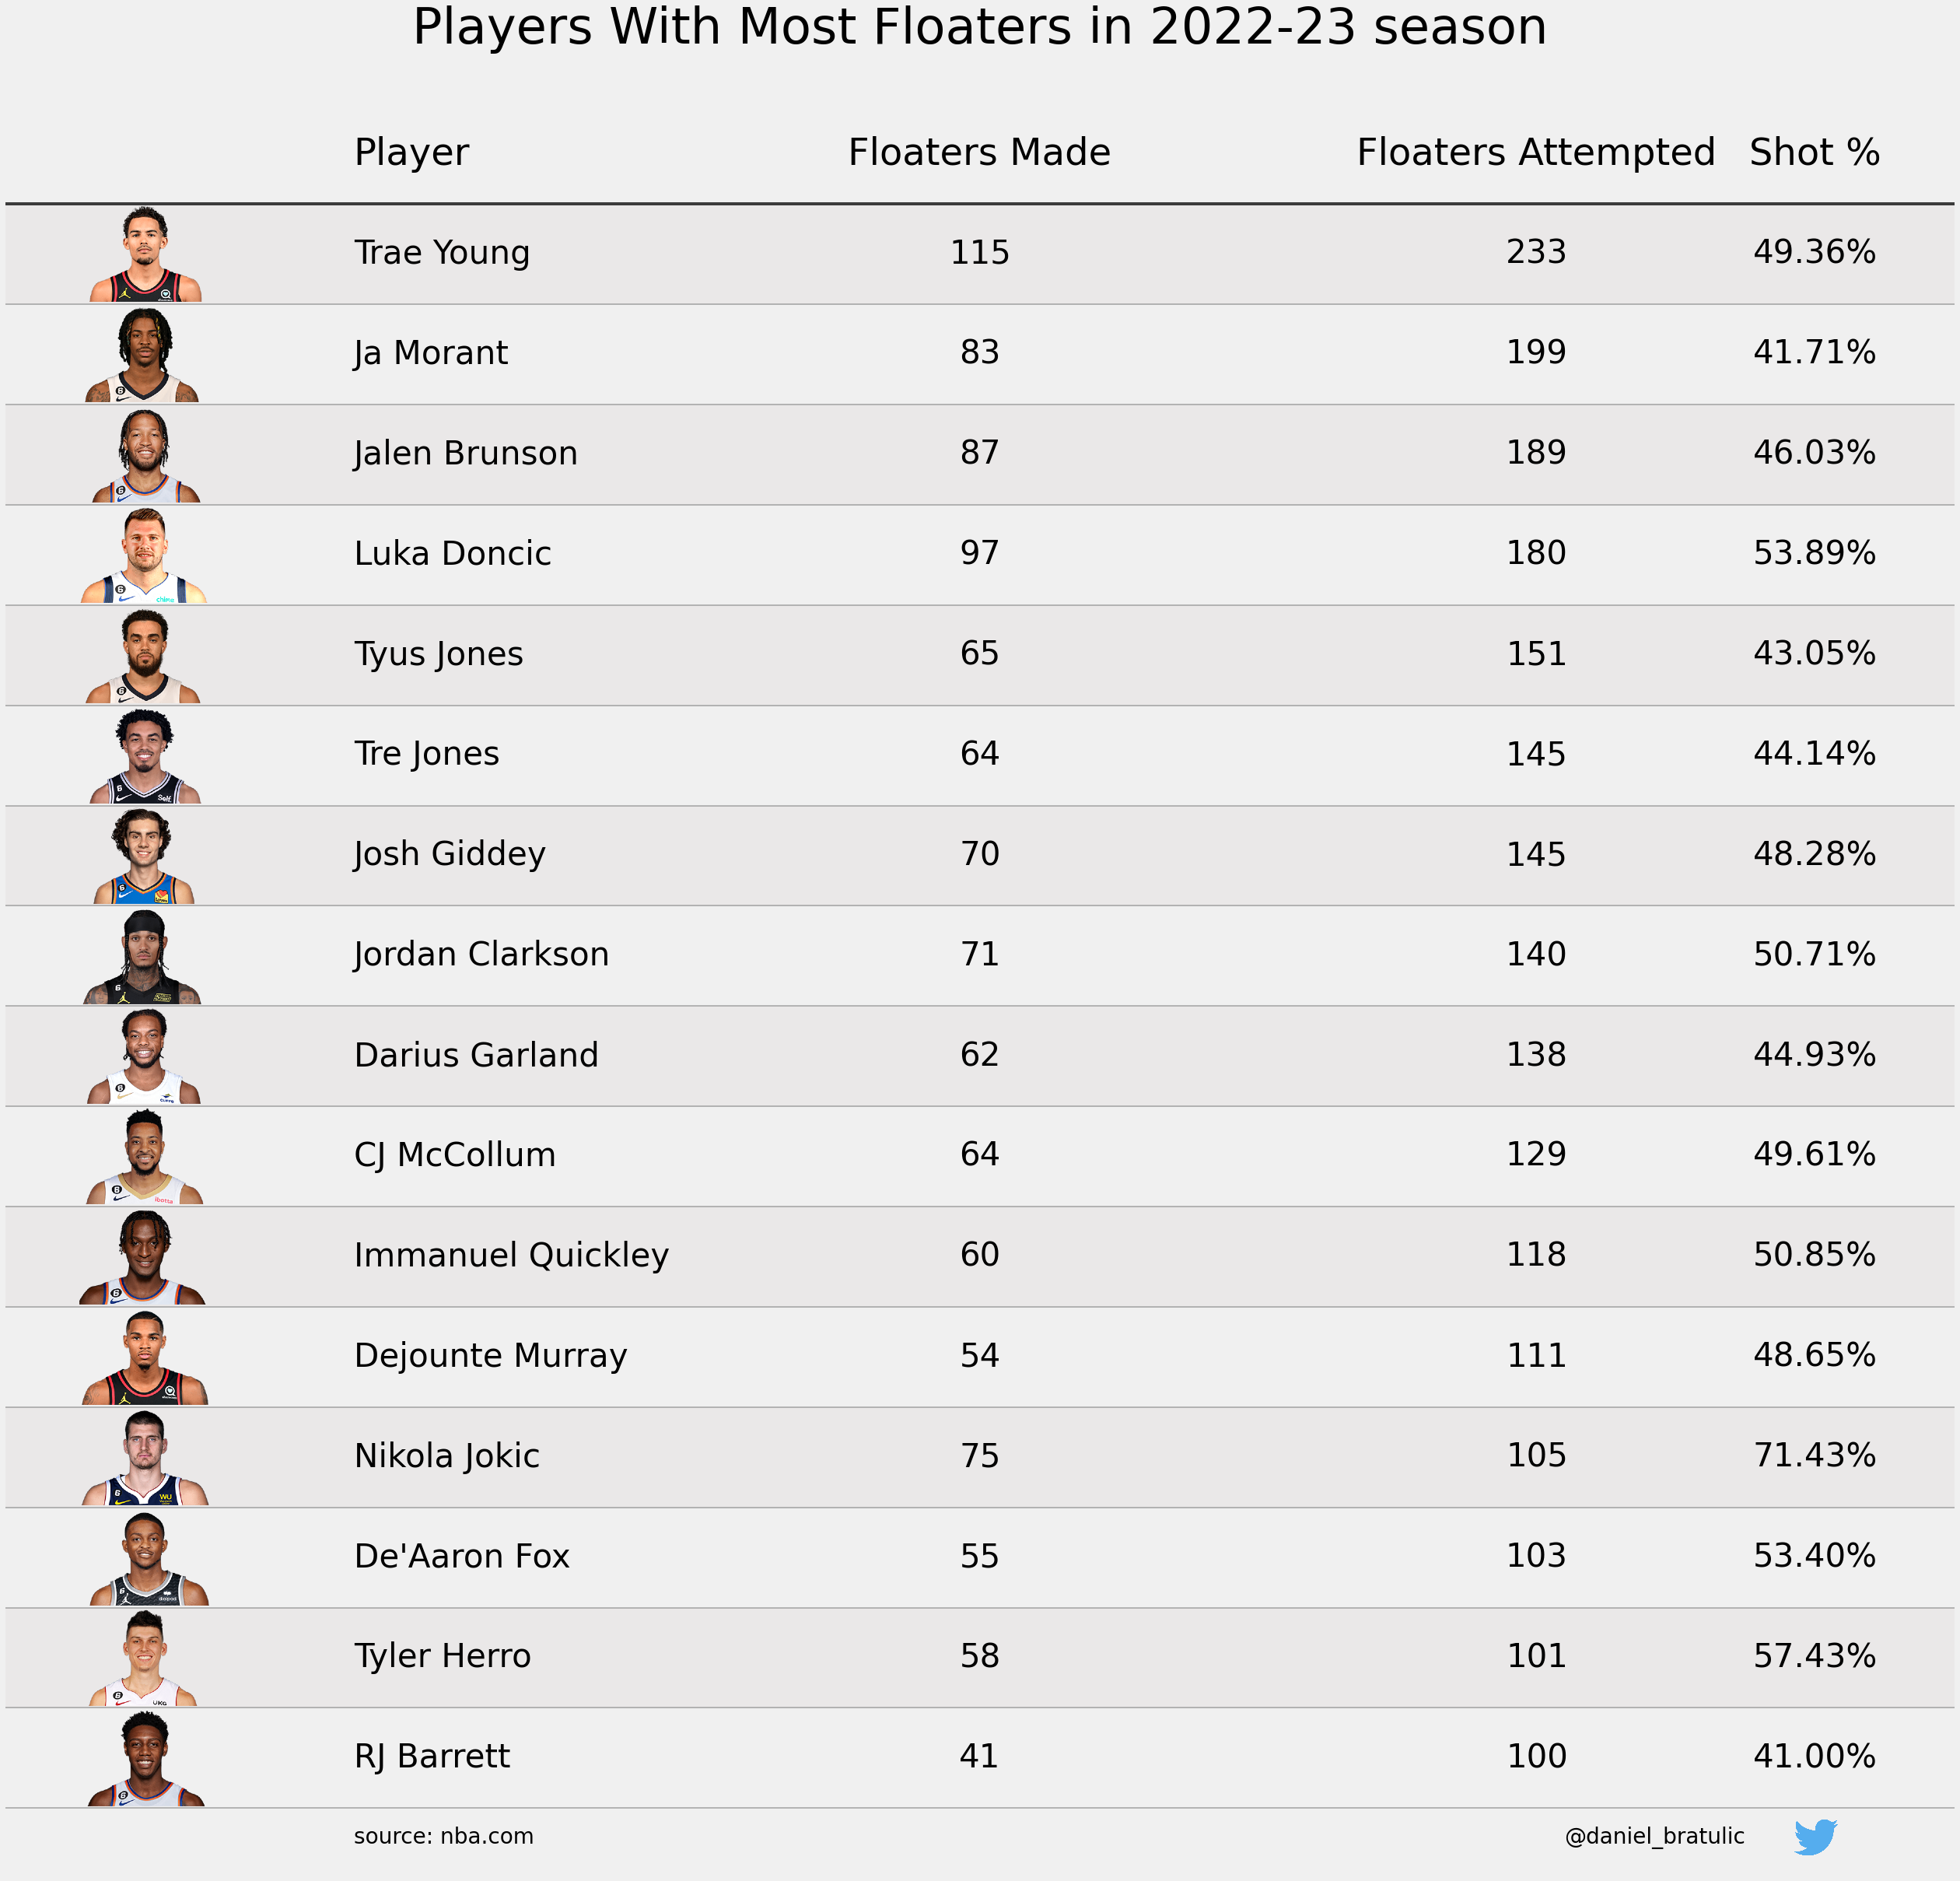

In [33]:
fig, ax = plt.subplots(figsize=(40, 40))
number_size = 42
font_size = 36
font_title = 48
title_size = 64
#top = 10

sorted_open_df = top_floaterers
top = len(top_floaterers)
for i in range(top):
    item = top_floaterers.iloc[i]
    try:
        player_id = find_players_by_full_name(item.PLAYER_NAME)[0]['id']
    except Exception:
        continue
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        rect = Rectangle((-4.5, y_coord + 0.5), width=15, height=1, fill=True, color=color)
        ax.add_patch(rect)
    
    ab = AnnotationBbox(get_player_img(player_id, zoom=0.65), (0.1, y_coord), frameon=False)
    ax.add_artist(ab)
    #ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.SEASON, size=font_size)
    ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.PLAYER_NAME, size=number_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    
    ax.text(x=0.7, y=y_coord, ha='center', va='center', s=f"{item.SHOT_MADE_FLAG}", size=number_size)
    ax.text(x=1.1, y=y_coord, ha='center', va='center', s=f"{item.SHOT_ATTEMPTED_FLAG}", size=number_size)
    ax.text(x=1.3, y=y_coord, ha='center', va='center', s=f"{item.SHOT_PCT:.2f}%", size=number_size)
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
#ax.text(x=0.25, y=top, s='Season', ha='left', va='center', size=font_title)
ax.text(x=0.25, y=top, s='Player', ha='left', va='center', size=font_title)
ax.text(x=0.7, y=top, ha='center', va='center', s="Floaters Made", size=font_title)
ax.text(x=1.1, y=top, ha='center', va='center', s="Floaters Attempted", size=font_title)
ax.text(x=1.3, y=top, ha='center', va='center', s="Shot %", size=font_title)


ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Players With Most Floaters in 2022-23 season", size=title_size)
#plt.suptitle("(Top 20 players in total blocks in 2022-23)", size=title_size-10, y=0.9, )
    
ax.set_ylim(bottom=-1.1, top=top+1)
ax.set_xlim(left=-0, right=1.4)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.05), (1.3, -0.8), frameon=False)
ax.add_artist(ab)
ax.text(x=1.25, y=-0.85, ha='right', s='@daniel_bratulic', size=28)
ax.text(x=0.25, y=-0.85, ha='left', s='source: nba.com', size=28)
plt.savefig('top_floaters.png', dpi=120, bbox_inches='tight')